In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import zipfile
from tqdm import tqdm
import pytz

# Load Data + Time Zone

In [ ]:
# Display all rows
pd.set_option('display.max_rows', None)

In [2]:
# ======== Load real-time data ========
df = pd.read_csv("/Users/kmcho/anaconda_projects/GTFS/converted_gtfs.csv", parse_dates=["vehicle_timestamp"])

utc = pytz.utc
eastern = pytz.timezone("America/New_York")
df["vehicle_timestamp"] = df["vehicle_timestamp"].dt.tz_localize(utc)
df["vehicle_timestamp_est"] = df["vehicle_timestamp"].dt.tz_convert(eastern)

c2_trips = df[df["vehicle_trip_routeId"] == "C2"].copy()

# ======== Function to load static GTFS data ========
def load_gtfs_file(zip_path, file_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(file_name) as f:
            return pd.read_csv(f)

# ======== Load static GTFS files ========
static_gtfs_path = '/Users/kmcho/anaconda_projects/GTFS/bus-gtfs-static.zip'
stops_df = load_gtfs_file(static_gtfs_path, 'stops.txt')
stop_times_df = load_gtfs_file(static_gtfs_path, 'stop_times.txt')
trips_df = load_gtfs_file(static_gtfs_path, 'trips.txt')

In [3]:
c2_trips

,header_timestamp,id,vehicle_trip_tripId,vehicle_trip_startDate,vehicle_trip_routeId,vehicle_position_latitude,vehicle_position_longitude,vehicle_position_bearing,vehicle_position_speed,vehicle_currentStopSequence,vehicle_currentStatus,vehicle_timestamp,vehicle_stopId,vehicle_vehicle_id,vehicle_occupancyStatus,vehicle_trip_scheduleRelationship,vehicle_timestamp_est
123531,2024-06-01 09:59:41,7342,34380070,20240601,C2,39.06153,-77.11673,137.00000,0.000000,2,STOPPED_AT,2024-06-01 09:44:06+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:44:06-04:00
123718,2024-06-01 09:59:41,7342,34380070,20240601,C2,39.06153,-77.11673,137.00000,0.000000,2,STOPPED_AT,2024-06-01 09:44:06+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:44:06-04:00
123783,2024-06-01 09:59:41,7342,34380070,20240601,C2,39.06153,-77.11673,137.00000,0.000000,2,STOPPED_AT,2024-06-01 09:44:06+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:44:06-04:00
124250,2024-06-01 09:59:41,7342,34380070,20240601,C2,39.06001,-77.11143,157.00000,14.935200,2,STOPPED_AT,2024-06-01 09:45:06+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:45:06-04:00
124326,2024-06-01 09:59:41,7342,34380070,20240601,C2,39.06150,-77.11504,88.00000,14.325601,2,STOPPED_AT,2024-06-01 09:44:36+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:44:36-04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2084496,2024-06-02 03:59:37,4506,4134070,20240601,C2,39.04151,-77.05815,304.22095,13.716001,67,STOPPED_AT,2024-06-02 03:17:01+00:00,10681,4506,NaN,NaN,2024-06-01 23:17:01-04:00
2084688,2024-06-02 03:59:37,4506,4134070,20240601,C2,39.04407,-77.06297,304.22095,17.068800,68,IN_TRANSIT_TO,2024-06-02 03:17:31+00:00,10704,4506,NaN,NaN,2024-06-01 23:17:31-04:00
2085001,2024-06-02 03:59:37,4506,4134070,20240601,C2,39.04852,-77.06913,321.06964,14.935200,70,IN_TRANSIT_TO,2024-06-02 03:18:43+00:00,10759,4506,NaN,NaN,2024-06-01 23:18:43-04:00
2085294,2024-06-02 03:59:37,4506,4134070,20240601,C2,39.04974,-77.07108,298.59903,15.544800,71,STOPPED_AT,2024-06-02 03:18:56+00:00,15259,4506,NaN,NaN,2024-06-01 23:18:56-04:00


# Delete Duplicates of Real-Time Data

In [5]:
# ======== Handle duplicate entries ========
trip_ids = c2_trips["vehicle_trip_tripId"].unique()
conflict_summary = []

for trip_id in tqdm(trip_ids):
    trip_df = c2_trips[c2_trips["vehicle_trip_tripId"] == trip_id].copy()
    trip_df_clean = trip_df.drop(columns=["header_timestamp"], errors='ignore')
    dup = trip_df_clean[trip_df_clean.duplicated(subset=["vehicle_timestamp"], keep=False)]
    check = dup.groupby("vehicle_timestamp").agg(lambda x: x.dropna().nunique())
    is_different = check > 1
    conflict_timestamps = is_different.any(axis=1)
    different = check[conflict_timestamps]
    if not different.empty:
        for ts in different.index:
            differing_cols = is_different.loc[ts][is_different.loc[ts]].index.tolist()
            unique_values = check.loc[ts][differing_cols].to_dict()
            conflict_summary.append({
                "trip_id": trip_id,
                "vehicle_timestamp": ts,
                "num_conflicts": len(dup[dup["vehicle_timestamp"] == ts]),
                "conflicting_columns": differing_cols,
                "unique_values_by_column": unique_values
            })

conflict_df = pd.DataFrame(conflict_summary)
c2_trips_cleaned = c2_trips.drop(columns=["header_timestamp"], errors='ignore').drop_duplicates()

100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 28.58it/s]


In [6]:
c2_trips_cleaned

,id,vehicle_trip_tripId,vehicle_trip_startDate,vehicle_trip_routeId,vehicle_position_latitude,vehicle_position_longitude,vehicle_position_bearing,vehicle_position_speed,vehicle_currentStopSequence,vehicle_currentStatus,vehicle_timestamp,vehicle_stopId,vehicle_vehicle_id,vehicle_occupancyStatus,vehicle_trip_scheduleRelationship,vehicle_timestamp_est
123531,7342,34380070,20240601,C2,39.06153,-77.11673,137.00000,0.000000,2,STOPPED_AT,2024-06-01 09:44:06+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:44:06-04:00
124250,7342,34380070,20240601,C2,39.06001,-77.11143,157.00000,14.935200,2,STOPPED_AT,2024-06-01 09:45:06+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:45:06-04:00
124326,7342,34380070,20240601,C2,39.06150,-77.11504,88.00000,14.325601,2,STOPPED_AT,2024-06-01 09:44:36+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:44:36-04:00
125302,7342,34380070,20240601,C2,39.06210,-77.11988,137.00000,11.277600,2,STOPPED_AT,2024-06-01 09:43:36+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:43:36-04:00
125752,7342,34380070,20240601,C2,39.05351,-77.10438,98.00000,0.000000,2,STOPPED_AT,2024-06-01 09:47:37+00:00,10628,7342,NaN,NaN,2024-06-01 05:47:37-04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2084123,4506,4134070,20240601,C2,39.04474,-77.06424,304.22095,12.801600,68,IN_TRANSIT_TO,2024-06-02 03:17:40+00:00,10704,4506,NaN,NaN,2024-06-01 23:17:40-04:00
2084688,4506,4134070,20240601,C2,39.04407,-77.06297,304.22095,17.068800,68,IN_TRANSIT_TO,2024-06-02 03:17:31+00:00,10704,4506,NaN,NaN,2024-06-01 23:17:31-04:00
2085001,4506,4134070,20240601,C2,39.04852,-77.06913,321.06964,14.935200,70,IN_TRANSIT_TO,2024-06-02 03:18:43+00:00,10759,4506,NaN,NaN,2024-06-01 23:18:43-04:00
2085294,4506,4134070,20240601,C2,39.04974,-77.07108,298.59903,15.544800,71,STOPPED_AT,2024-06-02 03:18:56+00:00,15259,4506,NaN,NaN,2024-06-01 23:18:56-04:00


# Attach Direction to Real-Time Data

In [7]:
# ======== Attach direction_id ========
direction_lookup = trips_df[["trip_id", "direction_id"]].drop_duplicates()
direction_lookup.rename(columns={"trip_id": "vehicle_trip_tripId"}, inplace=True)
c2_trips_cleaned = c2_trips_cleaned.merge(direction_lookup, on="vehicle_trip_tripId", how="left")

In [8]:
c2_trips_cleaned

,id,vehicle_trip_tripId,vehicle_trip_startDate,vehicle_trip_routeId,vehicle_position_latitude,vehicle_position_longitude,vehicle_position_bearing,vehicle_position_speed,vehicle_currentStopSequence,vehicle_currentStatus,vehicle_timestamp,vehicle_stopId,vehicle_vehicle_id,vehicle_occupancyStatus,vehicle_trip_scheduleRelationship,vehicle_timestamp_est,direction_id
0,7342,34380070,20240601,C2,39.06153,-77.11673,137.00000,0.000000,2,STOPPED_AT,2024-06-01 09:44:06+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:44:06-04:00,1
1,7342,34380070,20240601,C2,39.06001,-77.11143,157.00000,14.935200,2,STOPPED_AT,2024-06-01 09:45:06+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:45:06-04:00,1
2,7342,34380070,20240601,C2,39.06150,-77.11504,88.00000,14.325601,2,STOPPED_AT,2024-06-01 09:44:36+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:44:36-04:00,1
3,7342,34380070,20240601,C2,39.06210,-77.11988,137.00000,11.277600,2,STOPPED_AT,2024-06-01 09:43:36+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:43:36-04:00,1
4,7342,34380070,20240601,C2,39.05351,-77.10438,98.00000,0.000000,2,STOPPED_AT,2024-06-01 09:47:37+00:00,10628,7342,NaN,NaN,2024-06-01 05:47:37-04:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12383,4506,4134070,20240601,C2,39.04474,-77.06424,304.22095,12.801600,68,IN_TRANSIT_TO,2024-06-02 03:17:40+00:00,10704,4506,NaN,NaN,2024-06-01 23:17:40-04:00,0
12384,4506,4134070,20240601,C2,39.04407,-77.06297,304.22095,17.068800,68,IN_TRANSIT_TO,2024-06-02 03:17:31+00:00,10704,4506,NaN,NaN,2024-06-01 23:17:31-04:00,0
12385,4506,4134070,20240601,C2,39.04852,-77.06913,321.06964,14.935200,70,IN_TRANSIT_TO,2024-06-02 03:18:43+00:00,10759,4506,NaN,NaN,2024-06-01 23:18:43-04:00,0
12386,4506,4134070,20240601,C2,39.04974,-77.07108,298.59903,15.544800,71,STOPPED_AT,2024-06-02 03:18:56+00:00,15259,4506,NaN,NaN,2024-06-01 23:18:56-04:00,0


# Groupping and Sorting Real-Time Data

In [ ]:
# ======== Create trip_info_df ========
trip_info_list = []
for trip_id, group in c2_trips_cleaned.groupby("vehicle_trip_tripId"):
    group_sorted = group.sort_values("vehicle_timestamp")
    if group_sorted["vehicle_stopId"].notna().sum() >= 2:
        start_stop = group_sorted["vehicle_stopId"].iloc[0]
        end_stop = group_sorted["vehicle_stopId"].iloc[-1]
        direction_id = group_sorted["direction_id"].iloc[0]
        start_time = group_sorted["vehicle_timestamp"].min().tz_convert("America/New_York")
        end_time = group_sorted["vehicle_timestamp"].max().tz_convert("America/New_York")
        duration_min = (end_time - start_time).total_seconds() / 60
        trip_info_list.append({
            "trip_id": trip_id,
            "start_stop_id": start_stop,
            "end_stop_id": end_stop,
            "direction_id": direction_id,
            "start_time_est": start_time,
            "end_time_est": end_time,
            "duration_min": duration_min
        })

trip_info_df = pd.DataFrame(trip_info_list)

In [ ]:
trip_info_df

,trip_id,start_stop_id,end_stop_id,direction_id,start_time_est,end_time_est,duration_min
0,1008070,28170,12102,0,2024-06-01 14:16:15-04:00,2024-06-01 14:41:38-04:00,25.383333
1,1219070,12027,16955,0,2024-06-01 09:24:58-04:00,2024-06-01 10:22:17-04:00,57.316667
2,2030070,10628,12027,1,2024-06-01 18:24:22-04:00,2024-06-01 20:56:27-04:00,152.083333
3,2164070,10628,12027,1,2024-06-01 09:24:05-04:00,2024-06-01 11:11:29-04:00,107.400000
4,2853070,10628,12027,1,2024-06-01 18:48:27-04:00,2024-06-01 21:15:27-04:00,147.000000
...,...,...,...,...,...,...,...
70,50159070,10628,12027,1,2024-06-01 11:05:47-04:00,2024-06-01 12:47:02-04:00,101.250000
71,50394070,10628,10657,1,2024-06-01 20:41:43-04:00,2024-06-01 20:51:08-04:00,9.416667
72,50696070,12102,16955,0,2024-06-01 12:04:07-04:00,2024-06-01 12:54:46-04:00,50.650000
73,50708070,10628,12027,1,2024-06-01 13:51:48-04:00,2024-06-01 16:11:31-04:00,139.716667


# Add Stop Name

In [ ]:
# ======== Add stop_name ========
stop_id_to_name = stops_df.set_index("stop_id")["stop_name"].to_dict()
trip_info_df["start_stop_name"] = trip_info_df["start_stop_id"].map(stop_id_to_name)
trip_info_df["end_stop_name"] = trip_info_df["end_stop_id"].map(stop_id_to_name)

# Add Combo info

In [ ]:
# ======== Add combo_key ========
trip_info_df["combo_key"] = list(zip(
    trip_info_df["start_stop_id"],
    trip_info_df["end_stop_id"],
    trip_info_df["direction_id"]
))

In [12]:
trip_info_df

,trip_id,start_stop_id,end_stop_id,direction_id,start_time_est,end_time_est,duration_min,start_stop_name,end_stop_name,combo_key
0,1008070,28170,12102,0,2024-06-01 14:16:15-04:00,2024-06-01 14:41:38-04:00,25.383333,Stadium Dr+Denton Hall,Greenbelt Metro Dr+Cherrywood La,"(28170, 12102, 0)"
1,1219070,12027,16955,0,2024-06-01 09:24:58-04:00,2024-06-01 10:22:17-04:00,57.316667,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,"(12027, 16955, 0)"
2,2030070,10628,12027,1,2024-06-01 18:24:22-04:00,2024-06-01 20:56:27-04:00,152.083333,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,"(10628, 12027, 1)"
3,2164070,10628,12027,1,2024-06-01 09:24:05-04:00,2024-06-01 11:11:29-04:00,107.400000,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,"(10628, 12027, 1)"
4,2853070,10628,12027,1,2024-06-01 18:48:27-04:00,2024-06-01 21:15:27-04:00,147.000000,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,"(10628, 12027, 1)"
...,...,...,...,...,...,...,...,...,...,...
70,50159070,10628,12027,1,2024-06-01 11:05:47-04:00,2024-06-01 12:47:02-04:00,101.250000,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,"(10628, 12027, 1)"
71,50394070,10628,10657,1,2024-06-01 20:41:43-04:00,2024-06-01 20:51:08-04:00,9.416667,Wheaton+Bus Bay D,Veirs Mill Rd+University Bl,"(10628, 10657, 1)"
72,50696070,12102,16955,0,2024-06-01 12:04:07-04:00,2024-06-01 12:54:46-04:00,50.650000,Greenbelt Metro Dr+Cherrywood La,Wheaton+Bus Bay B,"(12102, 16955, 0)"
73,50708070,10628,12027,1,2024-06-01 13:51:48-04:00,2024-06-01 16:11:31-04:00,139.716667,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,"(10628, 12027, 1)"


In [14]:
# ======== Define grouped ========
grouped = trip_info_df.groupby(["start_stop_id", "end_stop_id", "direction_id"]).agg(
    num_trips=("trip_id", "count")
).reset_index()

grouped

,start_stop_id,end_stop_id,direction_id,num_trips
0,9798,16955,0,2
1,9926,16955,0,1
2,10628,10628,1,1
3,10628,10657,1,1
4,10628,12027,1,29
5,10628,19162,1,6
6,12027,10953,0,2
7,12027,12027,0,3
8,12027,16955,0,22
9,12027,21558,0,2


In [21]:
# ======== Add Stop name to grouped ========

# stop_id → stop_name 딕셔너리 생성
stop_id_to_name = stops_df.set_index("stop_id")["stop_name"].to_dict()

# 이름 컬럼 추가
grouped["start_stop_name"] = grouped["start_stop_id"].map(stop_id_to_name)
grouped["end_stop_name"] = grouped["end_stop_id"].map(stop_id_to_name)

# 컬럼 순서 재정렬 (보기 좋게)
grouped = grouped[[
    "start_stop_id", "start_stop_name",
    "end_stop_id", "end_stop_name",
    "direction_id", "num_trips"
]]

# 결과 확인
grouped

,start_stop_id,start_stop_name,end_stop_id,end_stop_name,direction_id,num_trips
0,9798,Campus Dr+Regents Dr,16955,Wheaton+Bus Bay B,0,2
1,9926,University Bl+Navahoe Dr,16955,Wheaton+Bus Bay B,0,1
2,10628,Wheaton+Bus Bay D,10628,Wheaton+Bus Bay D,1,1
3,10628,Wheaton+Bus Bay D,10657,Veirs Mill Rd+University Bl,1,1
4,10628,Wheaton+Bus Bay D,12027,Greenbelt+Bus Bay G,1,29
5,10628,Wheaton+Bus Bay D,19162,University Bl+15 Av,1,6
6,12027,Greenbelt+Bus Bay G,10953,Parklawn Dr+Twinbrook Pw,0,2
7,12027,Greenbelt+Bus Bay G,12027,Greenbelt+Bus Bay G,0,3
8,12027,Greenbelt+Bus Bay G,16955,Wheaton+Bus Bay B,0,22
9,12027,Greenbelt+Bus Bay G,21558,Twinbrook+Bus Bay A,0,2


In [15]:
# ======== Group timing information ======== 이건 필요 없는 것 같음
combo_time_info = []
for _, row in grouped.iterrows():
    s, e, d = row["start_stop_id"], row["end_stop_id"], row["direction_id"]
    subset = trip_info_df[
        (trip_info_df["start_stop_id"] == s) &
        (trip_info_df["end_stop_id"] == e) &
        (trip_info_df["direction_id"] == d)
    ]
    combo_time_info.append({
        "start_stop_id": s,
        "end_stop_id": e,
        "direction_id": d,
        "num_trips": len(subset),
        "first_departure_time (EST)": subset["start_time_est"].min(),
        "last_arrival_time (EST)": subset["end_time_est"].max()
    })

combo_time_df = pd.DataFrame(combo_time_info)
combo_time_df

,start_stop_id,end_stop_id,direction_id,num_trips,first_departure_time (EST),last_arrival_time (EST)
0,9798,16955,0,2,2024-06-01 13:07:58-04:00,2024-06-01 19:40:15-04:00
1,9926,16955,0,1,2024-06-01 19:20:02-04:00,2024-06-01 19:46:48-04:00
2,10628,10628,1,1,2024-06-01 17:43:06-04:00,2024-06-01 17:58:20-04:00
3,10628,10657,1,1,2024-06-01 20:41:43-04:00,2024-06-01 20:51:08-04:00
4,10628,12027,1,29,2024-06-01 05:43:36-04:00,2024-06-01 22:13:16-04:00
5,10628,19162,1,6,2024-06-01 10:04:21-04:00,2024-06-01 21:38:27-04:00
6,12027,10953,0,2,2024-06-01 20:56:57-04:00,2024-06-01 23:29:07-04:00
7,12027,12027,0,3,2024-06-01 12:47:32-04:00,2024-06-01 20:19:44-04:00
8,12027,16955,0,22,2024-06-01 06:35:17-04:00,2024-06-01 20:50:12-04:00
9,12027,21558,0,2,2024-06-01 20:29:34-04:00,2024-06-01 22:18:06-04:00


In [16]:
# ======== Add combo_name and map ========
combo_time_df = combo_time_df.sort_values("first_departure_time (EST)").reset_index(drop=True)
combo_time_df["combo_name"] = ["Combo {:02d}".format(i + 1) for i in range(len(combo_time_df))]
combo_time_df["combo_key"] = list(zip(
    combo_time_df["start_stop_id"],
    combo_time_df["end_stop_id"],
    combo_time_df["direction_id"]
))

combo_info_map = combo_time_df.set_index("combo_key")[["combo_name", "num_trips"]].to_dict("index")
combo_info_map

{(10628, 12027, 1): {'combo_name': 'Combo 01', 'num_trips': 29},
 (12027, 16955, 0): {'combo_name': 'Combo 02', 'num_trips': 22},
 (10628, 19162, 1): {'combo_name': 'Combo 03', 'num_trips': 6},
 (28170, 12102, 0): {'combo_name': 'Combo 04', 'num_trips': 2},
 (12102, 16955, 0): {'combo_name': 'Combo 05', 'num_trips': 2},
 (12027, 12027, 0): {'combo_name': 'Combo 06', 'num_trips': 3},
 (9798, 16955, 0): {'combo_name': 'Combo 07', 'num_trips': 2},
 (28170, 16955, 0): {'combo_name': 'Combo 08', 'num_trips': 1},
 (10628, 10628, 1): {'combo_name': 'Combo 09', 'num_trips': 1},
 (9926, 16955, 0): {'combo_name': 'Combo 10', 'num_trips': 1},
 (12027, 21558, 0): {'combo_name': 'Combo 11', 'num_trips': 2},
 (10628, 10657, 1): {'combo_name': 'Combo 12', 'num_trips': 1},
 (12027, 10953, 0): {'combo_name': 'Combo 13', 'num_trips': 2},
 (28167, 9752, 0): {'combo_name': 'Combo 14', 'num_trips': 1}}

In [18]:
# ======== Calculate trip order within each combo ========
grouped_order = {}
for combo, group in trip_info_df.groupby("combo_key"):
    ordered = group.sort_values("start_time_est")
    grouped_order[combo] = {trip_id: i+1 for i, trip_id in enumerate(ordered["trip_id"])}

In [20]:
# ======== Generate combo_description column ========
def generate_combo_description(row):
    info = combo_info_map.get(row["combo_key"])
    order = grouped_order.get(row["combo_key"], {}).get(row["trip_id"], None)
    if info and order:
        return f"{info['combo_name']}: Trip {order} of {info['num_trips']}"
    return "Unknown combo"

trip_info_df["combo_description"] = trip_info_df.apply(generate_combo_description, axis=1)

# Sort and reorder columns
trip_info_df2 = trip_info_df[[
    "trip_id", "start_stop_id", "end_stop_id",
    "start_stop_name", "end_stop_name", "direction_id",
    "start_time_est", "end_time_est", "duration_min", "combo_description"
]].sort_values("start_time_est")

trip_info_df2

,trip_id,start_stop_id,end_stop_id,start_stop_name,end_stop_name,direction_id,start_time_est,end_time_est,duration_min,combo_description
51,34380070,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1,2024-06-01 05:43:36-04:00,2024-06-01 06:58:07-04:00,74.516667,Combo 01: Trip 1 of 29
13,10091070,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0,2024-06-01 06:35:17-04:00,2024-06-01 08:21:56-04:00,106.650000,Combo 02: Trip 1 of 22
31,20725070,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0,2024-06-01 06:35:24-04:00,2024-06-01 07:37:15-04:00,61.850000,Combo 02: Trip 2 of 22
67,47269070,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1,2024-06-01 06:40:11-04:00,2024-06-01 07:53:25-04:00,73.233333,Combo 01: Trip 2 of 29
22,15502070,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0,2024-06-01 06:58:29-04:00,2024-06-01 07:58:39-04:00,60.166667,Combo 02: Trip 3 of 22
...,...,...,...,...,...,...,...,...,...,...
65,46520070,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1,2024-06-01 20:50:43-04:00,2024-06-01 22:13:16-04:00,82.550000,Combo 01: Trip 29 of 29
61,44759070,12027,10953,Greenbelt+Bus Bay G,Parklawn Dr+Twinbrook Pw,0,2024-06-01 20:56:57-04:00,2024-06-01 22:00:01-04:00,63.066667,Combo 13: Trip 1 of 2
49,32724070,12027,21558,Greenbelt+Bus Bay G,Twinbrook+Bus Bay A,0,2024-06-01 21:15:59-04:00,2024-06-01 22:18:06-04:00,62.116667,Combo 11: Trip 2 of 2
54,35051070,28167,9752,Stadium Dr+Regents Dr,University Bl+Tulane Dr,0,2024-06-01 21:55:08-04:00,2024-06-01 22:42:37-04:00,47.483333,Combo 14: Trip 1 of 1


# Combo Info

In [23]:
# combo_description에서 앞부분만 추출 ("Combo 01" 등)
trip_info_df2["combo_prefix"] = trip_info_df2["combo_description"].str.extract(r"(Combo \d{2})")

# combo별 trip 수 세기
combo_trip_counts = trip_info_df2.groupby("combo_prefix").size().reset_index(name="num_trips")

# 정렬 (옵션)
combo_trip_counts = combo_trip_counts.sort_values("combo_prefix").reset_index(drop=True)

# 결과 확인
combo_trip_counts

,combo_prefix,num_trips
0,Combo 01,29
1,Combo 02,22
2,Combo 03,6
3,Combo 04,2
4,Combo 05,2
5,Combo 06,3
6,Combo 07,2
7,Combo 08,1
8,Combo 09,1
9,Combo 10,1


In [53]:
# Combo 03 ~ Combo 14를 타겟으로
target_combos = [f"Combo {i:02d}" for i in range(1, 2)]
filtered_df = trip_info_df2[trip_info_df2["combo_prefix"].isin(target_combos)].copy()

# 필요한 열만 추출해서 보기 좋게 정리
trip_time_table = filtered_df[[
    "combo_prefix", "trip_id", "start_time_est", "end_time_est", "duration_min"
]].sort_values(["combo_prefix", "start_time_est"]).reset_index(drop=True)

# 결과 확인
trip_time_table.head(50)

,combo_prefix,trip_id,start_time_est,end_time_est,duration_min
0,Combo 01,34380070,2024-06-01 05:43:36-04:00,2024-06-01 06:58:07-04:00,74.516667
1,Combo 01,47269070,2024-06-01 06:40:11-04:00,2024-06-01 07:53:25-04:00,73.233333
2,Combo 01,17121070,2024-06-01 07:07:17-04:00,2024-06-01 08:30:03-04:00,82.766667
3,Combo 01,28287070,2024-06-01 07:37:45-04:00,2024-06-01 08:53:51-04:00,76.100000
4,Combo 01,15104070,2024-06-01 08:02:58-04:00,2024-06-01 09:24:25-04:00,81.450000
5,Combo 01,29749070,2024-06-01 08:22:30-04:00,2024-06-01 09:49:56-04:00,87.433333
6,Combo 01,48150070,2024-06-01 08:41:36-04:00,2024-06-01 10:14:27-04:00,92.850000
7,Combo 01,18912070,2024-06-01 08:48:57-04:00,2024-06-01 10:42:53-04:00,113.933333
8,Combo 01,2164070,2024-06-01 09:24:05-04:00,2024-06-01 11:11:29-04:00,107.400000
9,Combo 01,17039070,2024-06-01 10:22:47-04:00,2024-06-01 12:03:44-04:00,100.950000


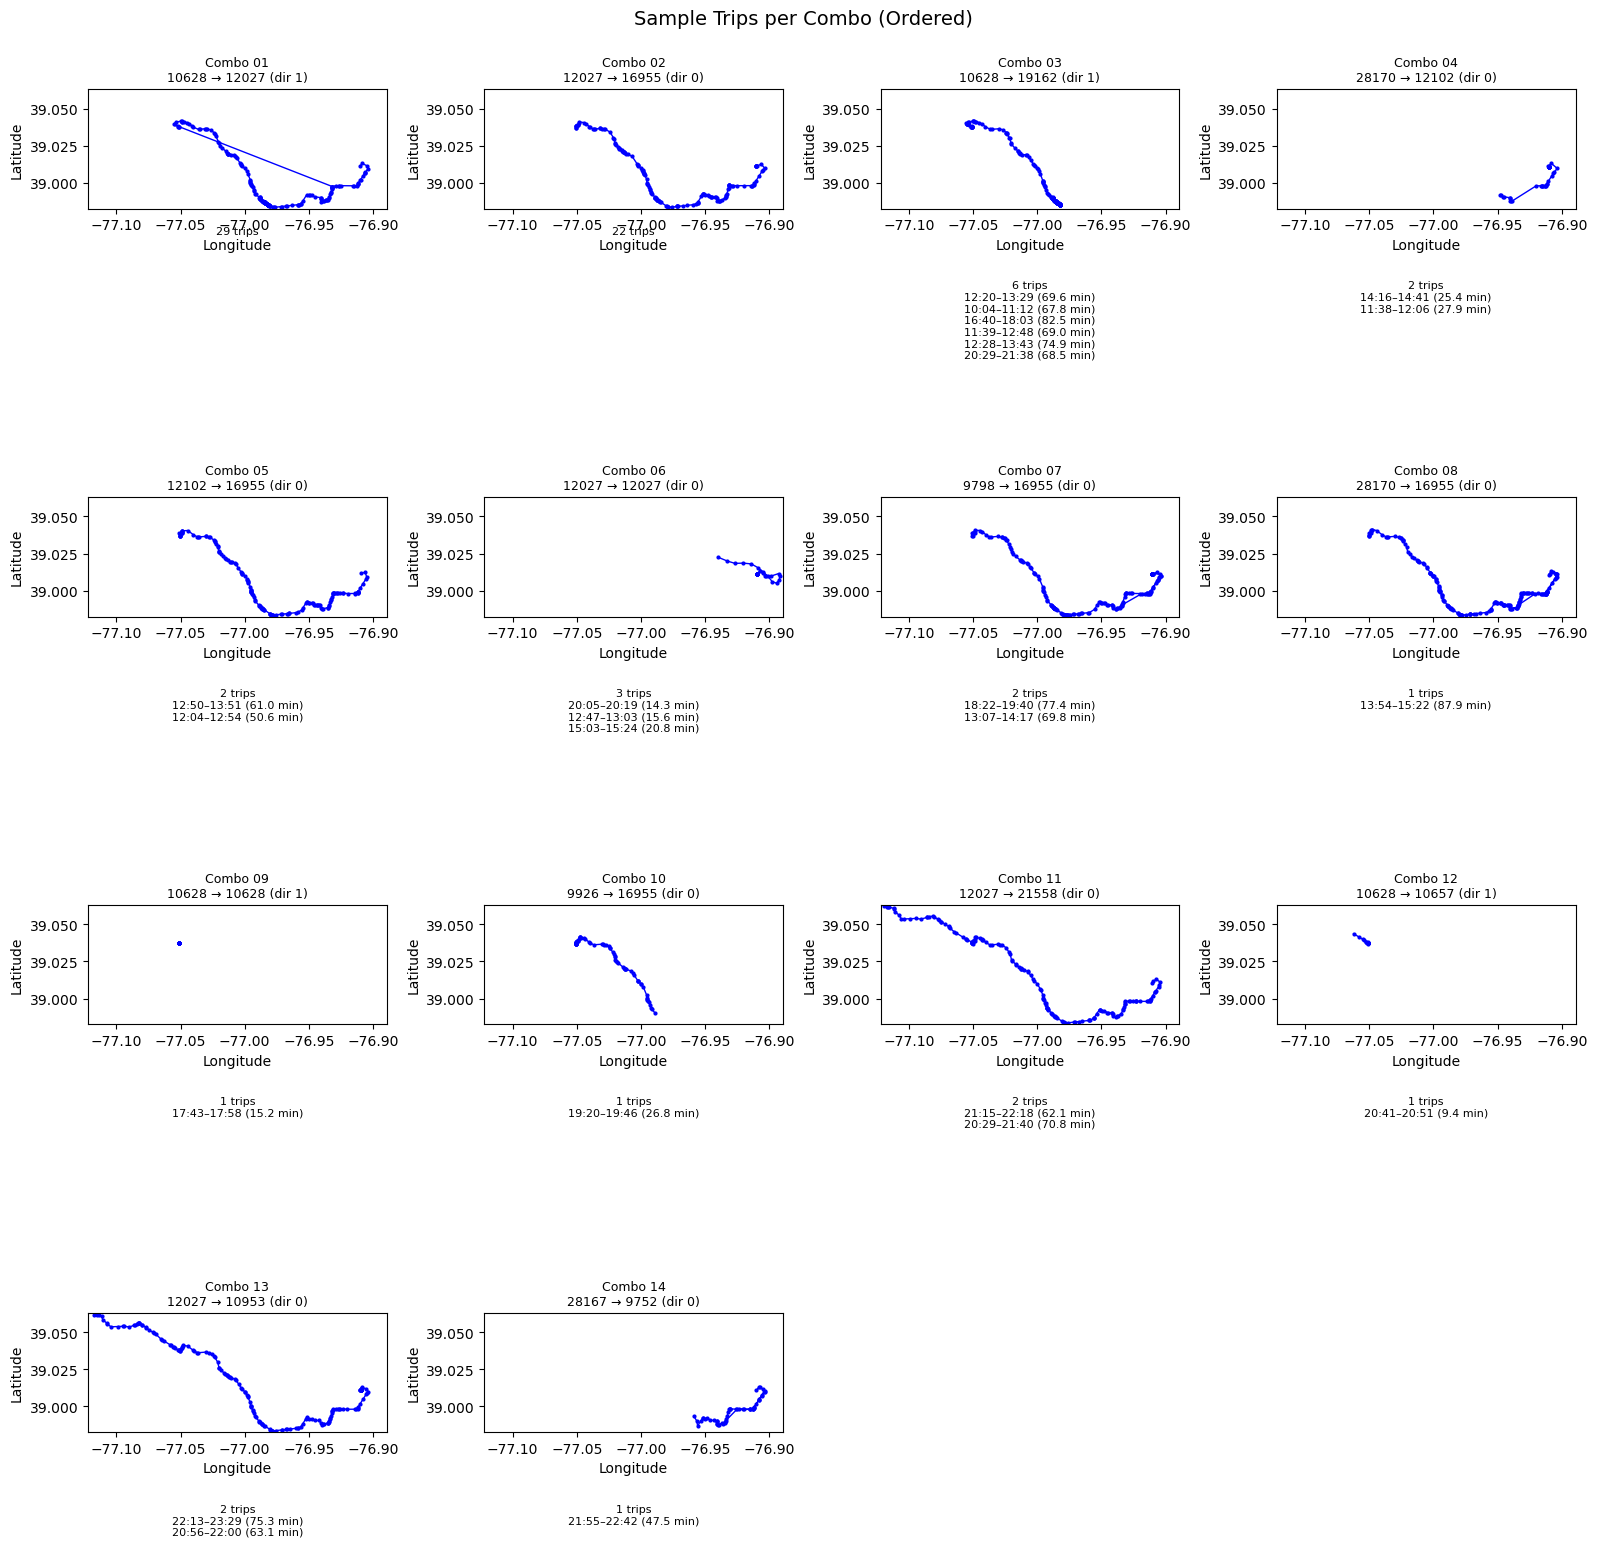

In [25]:
import matplotlib.pyplot as plt
import math

# Create combo_key
combo_time_df["combo_key"] = list(zip(
    combo_time_df["start_stop_id"],
    combo_time_df["end_stop_id"],
    combo_time_df["direction_id"]
))
trip_info_df["combo_key"] = list(zip(
    trip_info_df["start_stop_id"],
    trip_info_df["end_stop_id"],
    trip_info_df["direction_id"]
))

# Dictionary for mapping combo_key to combo_name
combo_name_map = combo_time_df.set_index("combo_key")["combo_name"].to_dict()

# Create a list of combo_keys in combo_name order
combo_keys_in_order = combo_time_df["combo_key"].tolist()

# Select one representative trip for each combo_key
representative_trips = []
for combo_key in combo_keys_in_order:
    trip_row = trip_info_df[trip_info_df["combo_key"] == combo_key].iloc[0]
    representative_trips.append(trip_row)

# Set subplot size
num_plots = len(representative_trips)
cols = 4
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

# 전체 데이터에서 경도/위도 범위 구하기
all_lon = c2_trips_cleaned["vehicle_position_longitude"]
all_lat = c2_trips_cleaned["vehicle_position_latitude"]
lon_min, lon_max = all_lon.min(), all_lon.max()
lat_min, lat_max = all_lat.min(), all_lat.max()

# padding 추가
padding_ratio = 0.01
lon_padding = (lon_max - lon_min) * padding_ratio
lat_padding = (lat_max - lat_min) * padding_ratio
xlim = (lon_min - lon_padding, lon_max + lon_padding)
ylim = (lat_min - lat_padding, lat_max + lat_padding)

# combo 정보 mapping
combo_info_map = combo_time_df.set_index("combo_key")[["combo_name", "num_trips"]].to_dict("index")
trip_info_df["combo_prefix"] = trip_info_df["combo_description"].str.extract(r"(Combo \d{2})")

# 그래프 그리기
for idx, row in enumerate(representative_trips):
    ax = axes[idx]
    trip_id = row["trip_id"]
    trip_df = c2_trips_cleaned[c2_trips_cleaned["vehicle_trip_tripId"] == trip_id].copy()

    if len(trip_df) < 5:
        ax.set_title("Too short")
        ax.axis("off")
        continue

    trip_df = trip_df.sort_values("vehicle_timestamp")
    lon = trip_df["vehicle_position_longitude"]
    lat = trip_df["vehicle_position_latitude"]

    combo_key = row["combo_key"]
    combo_name = combo_name_map.get(combo_key, "Unknown")
    num_trips = combo_info_map.get(combo_key, {}).get("num_trips", "N/A")

    # Plot
    ax.plot(lon, lat, marker='o', markersize=2, linewidth=1, color='blue')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(f"{combo_name}\n{row['start_stop_id']} → {row['end_stop_id']} (dir {row['direction_id']})", fontsize=9)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Combo 03~14: 각 trip의 출발-도착 시간 및 duration 추가
    if combo_name in [f"Combo {i:02d}" for i in range(3, 15)]:
        trip_rows = trip_info_df[trip_info_df["combo_prefix"] == combo_name]
        times_text = "\n".join([
            f"{t['start_time_est'].strftime('%H:%M')}–{t['end_time_est'].strftime('%H:%M')} ({t['duration_min']:.1f} min)"
            for _, t in trip_rows.iterrows()
        ])
        ax.text(0.5, -0.6, f"{num_trips} trips\n{times_text}",
                transform=ax.transAxes,
                fontsize=8, ha="center", va="top")
    else:
        # Combo 01, 02 등은 trip 수만 표기
        ax.text(0.5, -0.15, f"{num_trips} trips",
                transform=ax.transAxes,
                fontsize=8, ha="center", va="top")

# Hide empty subplots
for i in range(num_plots, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.suptitle("Sample Trips per Combo (Ordered)", fontsize=14, y=1.02)
plt.show()


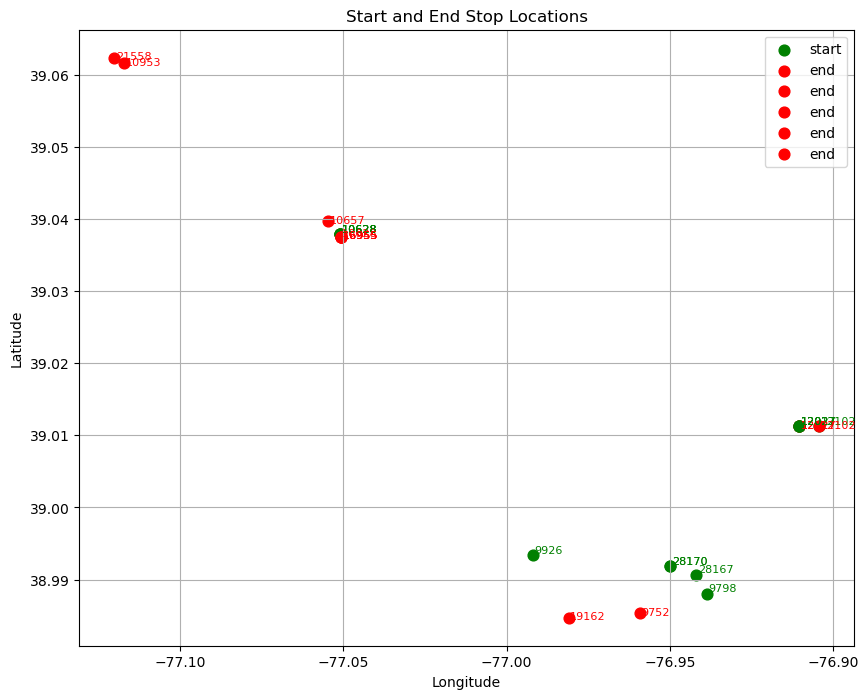

In [32]:
# 그룹핑 결과 복사 (리스트 또는 DataFrame)
grouped_data = [
    (9798, 16955, 0),
    (9926, 16955, 0),
    (10628, 10628, 1),
    (10628, 10657, 1),
    (10628, 12027, 1),
    (10628, 19162, 1),
    (12027, 10953, 0),
    (12027, 12027, 0),
    (12027, 16955, 0),
    (12027, 21558, 0),
    (12102, 16955, 0),
    (28167, 9752, 0),
    (28170, 12102, 0),
    (28170, 16955, 0)
]

# 시각화 대상 stop_id 집합
stop_ids = set()
for start, end, _ in grouped_data:
    stop_ids.add(start)
    stop_ids.add(end)

# 위치 정보 가져오기
selected_stops = stops_df[stops_df["stop_id"].isin(stop_ids)]

# stop_id → (lat, lon) 매핑
stop_locations = {
    row["stop_id"]: (row["stop_lat"], row["stop_lon"])
    for _, row in selected_stops.iterrows()
}

# 시각화
plt.figure(figsize=(10, 8))

for start, end, _ in grouped_data:
    # 출발지 (green)
    if start in stop_locations:
        lat, lon = stop_locations[start]
        plt.scatter(lon, lat, color='green', label='start' if start == grouped_data[0][0] else "", s=60)
        plt.text(lon + 0.0005, lat + 0.0003, str(start), fontsize=8, color='green')
    
    # 도착지 (red)
    if end in stop_locations:
        lat, lon = stop_locations[end]
        plt.scatter(lon, lat, color='red', label='end' if end == grouped_data[0][1] else "", s=60)
        plt.text(lon + 0.0005, lat - 0.0003, str(end), fontsize=8, color='red')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Start and End Stop Locations")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
import folium

# ===== Initialize the map =====
# Set the map center based on the start stop of the first combo
first_start_stop = trip_info_df.iloc[0]["start_stop_id"]
first_lat = stops_df.loc[stops_df["stop_id"] == first_start_stop, "stop_lat"].values[0]
first_lon = stops_df.loc[stops_df["stop_id"] == first_start_stop, "stop_lon"].values[0]
m = folium.Map(location=[first_lat, first_lon], zoom_start=12)

# ===== Mark all start and end stops =====
for _, row in trip_info_df.iterrows():
    start_id = row["start_stop_id"]
    end_id = row["end_stop_id"]
    
    start_info = stops_df[stops_df["stop_id"] == start_id].iloc[0]
    end_info = stops_df[stops_df["stop_id"] == end_id].iloc[0]

    folium.Marker(
        location=[start_info["stop_lat"], start_info["stop_lon"]],
        icon=folium.Icon(color="green"),
        popup=f"Start: {start_info['stop_name']} ({start_id})"
    ).add_to(m)

    folium.Marker(
        location=[end_info["stop_lat"], end_info["stop_lon"]],
        icon=folium.Icon(color="red"),
        popup=f"End: {end_info['stop_name']} ({end_id})"
    ).add_to(m)

# ===== Add a polyline for a specific combo (e.g., combo_idx = 4 → Combo 05) =====
combo_idx = 1-1  # 예: Combo 05 → 인덱스는 0부터 시작

combo_row = combo_time_df.iloc[combo_idx]
start = combo_row["start_stop_id"]
end = combo_row["end_stop_id"]
direction = combo_row["direction_id"]

# Select a representative trip_id
target_trip = trip_info_df[
    (trip_info_df["start_stop_id"] == start) &
    (trip_info_df["end_stop_id"] == end) &
    (trip_info_df["direction_id"] == direction)
].sort_values("start_time_est").iloc[0]["trip_id"]

# Get the trip path
trip_df = c2_trips_cleaned[c2_trips_cleaned["vehicle_trip_tripId"] == target_trip].sort_values("vehicle_timestamp")
coords = list(zip(trip_df["vehicle_position_latitude"], trip_df["vehicle_position_longitude"]))

# Add the polyline
folium.PolyLine(locations=coords, color="blue", weight=5, opacity=0.7, tooltip=f"Combo {combo_idx+1:02d}").add_to(m)

# ===== Add stop points: stops that the selected trip passes through =====
trip_schedule = stop_times_df[stop_times_df["trip_id"] == target_trip].copy()
trip_schedule = trip_schedule.merge(
    stops_df[["stop_id", "stop_name", "stop_lat", "stop_lon"]],
    on="stop_id", how="left"
)

for _, stop in trip_schedule.iterrows():
    folium.CircleMarker(
        location=[stop["stop_lat"], stop["stop_lon"]],
        radius=4,
        color="blue",
        fill=True,
        fill_opacity=0.6,
        popup=f"{stop['stop_name']} ({stop['stop_id']})"
    ).add_to(m)


# Display the map
m


The blue line is a LineString connecting real-time GPS locations generated from `trip_df`, 
and the blue dots represent bus stop locations (`stop_lat`, `stop_lon`) from `stops_df`.

# Shape Info

In [26]:
# C2 노선의 모든 trip
c2_static_trips = trips_df[trips_df["route_id"] == "C2"]

# 출발/도착 정류장 조합 확인
trip_ids = c2_static_trips["trip_id"].unique()
c2_stop_times = stop_times_df[stop_times_df["trip_id"].isin(trip_ids)]

# 각 trip의 시작/종료 정류장
first_last_stops = c2_stop_times.sort_values(["trip_id", "stop_sequence"]).groupby("trip_id").agg(
    start_stop_id=("stop_id", "first"),
    end_stop_id=("stop_id", "last")
).reset_index()

# direction_id와 병합
trip_overview = c2_static_trips[["trip_id", "direction_id", "shape_id"]].merge(
    first_last_stops, on="trip_id"
)

# 결과 확인
trip_overview.head()

,trip_id,direction_id,shape_id,start_stop_id,end_stop_id
0,30387100,1,C2:02,10628,12027
1,42309100,0,C2:01,12027,16955
2,34380070,1,C2:02,10628,12027
3,15502070,0,C2:01,12027,16955
4,20944090,1,C2:02,10628,12027


In [27]:
shapes_df = load_gtfs_file(static_gtfs_path, 'shapes.txt')

/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


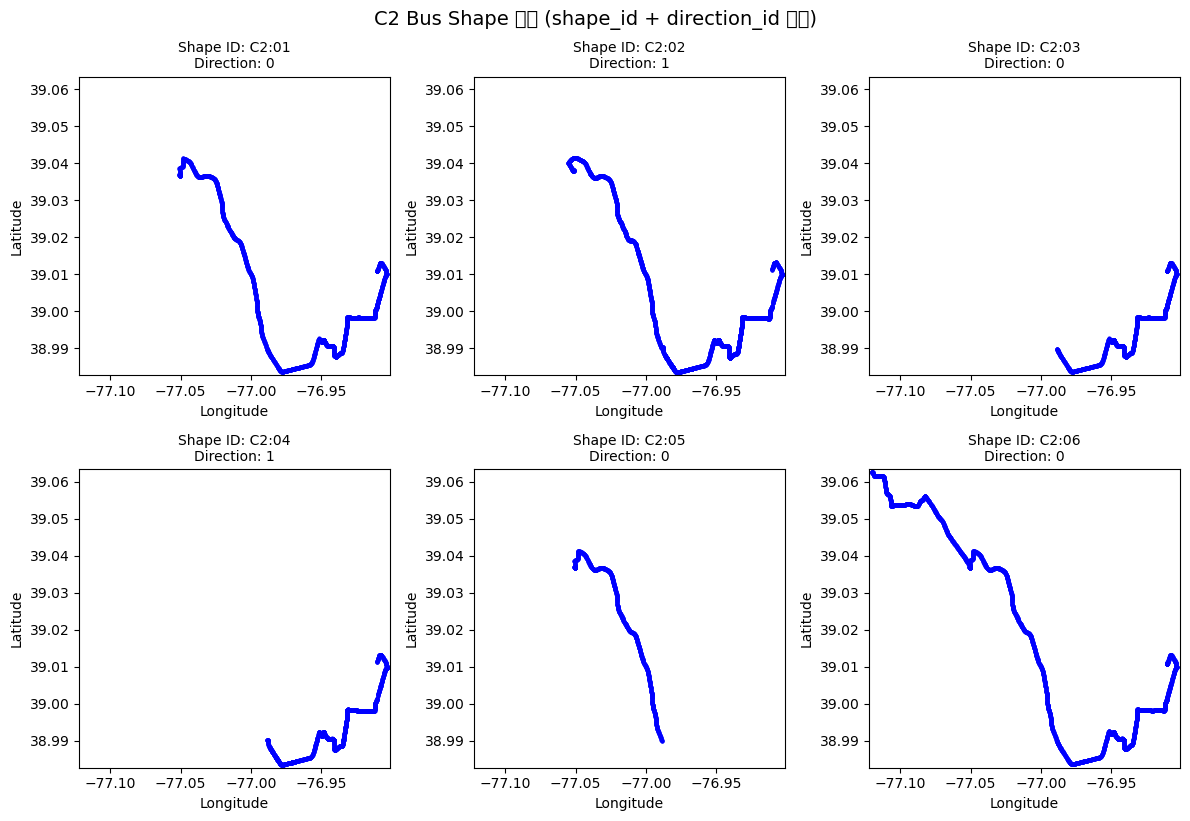

In [28]:
import matplotlib.pyplot as plt
import math

# Step 1: C2 노선의 trip에서 사용된 shape_id, direction_id 추출 (중복 제거)
c2_trips = trips_df[trips_df["route_id"] == "C2"]
c2_shape_info = c2_trips[["shape_id", "direction_id"]].drop_duplicates().sort_values("shape_id").reset_index(drop=True)

# Step 2: subplot 설정
num_shapes = len(c2_shape_info)
cols = 3
rows = math.ceil(num_shapes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

# Step 3: 전체 범위 계산 (축 고정용)
c2_shape_ids = c2_shape_info["shape_id"].unique()
all_c2_shapes = shapes_df[shapes_df["shape_id"].isin(c2_shape_ids)]
lon_min = all_c2_shapes["shape_pt_lon"].min()
lon_max = all_c2_shapes["shape_pt_lon"].max()
lat_min = all_c2_shapes["shape_pt_lat"].min()
lat_max = all_c2_shapes["shape_pt_lat"].max()

# padding
padding_ratio = 0.01
lon_padding = (lon_max - lon_min) * padding_ratio
lat_padding = (lat_max - lat_min) * padding_ratio
xlim = (lon_min - lon_padding, lon_max + lon_padding)
ylim = (lat_min - lat_padding, lat_max + lat_padding)

# Step 4: shape_id별 궤적 시각화
for idx, row in c2_shape_info.iterrows():
    ax = axes[idx]
    shape_id = row["shape_id"]
    direction = row["direction_id"]

    shape_points = shapes_df[shapes_df["shape_id"] == shape_id].sort_values("shape_pt_sequence")
    lon = shape_points["shape_pt_lon"]
    lat = shape_points["shape_pt_lat"]

    ax.plot(lon, lat, marker='o', markersize=2, linewidth=1, color='blue')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(f"Shape ID: {shape_id}\nDirection: {direction}", fontsize=10)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# 나머지 빈 subplot 제거
for i in range(num_shapes, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.suptitle("C2 Bus Shape 경로 (shape_id + direction_id 기준)", fontsize=14, y=1.02)
plt.show()


In [29]:
0: To West (To Wheaton, Takoma Langley, Twinbrook)
1: To East (To Greenbelt)

SyntaxError: illegal target for annotation (2829258071.py, line 1)

In [30]:
# C2 노선의 trip만 필터링
c2_trips = trips_df[trips_df["route_id"] == "C2"]

# stop_times와 병합하여 trip의 출발/도착 정류장 확인
trip_ids = c2_trips["trip_id"].unique()
c2_stop_times = stop_times_df[stop_times_df["trip_id"].isin(trip_ids)]

# trip별 첫 정류장, 마지막 정류장 추출
first_last_stops = c2_stop_times.sort_values(["trip_id", "stop_sequence"]).groupby("trip_id").agg(
    start_stop_id=("stop_id", "first"),
    end_stop_id=("stop_id", "last")
).reset_index()

# 정류장 이름 붙이기
stop_id_to_name = stops_df.set_index("stop_id")["stop_name"].to_dict()
first_last_stops["start_stop_name"] = first_last_stops["start_stop_id"].map(stop_id_to_name)
first_last_stops["end_stop_name"] = first_last_stops["end_stop_id"].map(stop_id_to_name)

# direction_id 붙이기
first_last_stops = first_last_stops.merge(
    c2_trips[["trip_id", "direction_id"]], on="trip_id", how="left"
)

# direction별 대표 5개 trip 확인
first_last_stops.sort_values("trip_id").groupby("direction_id").head(50)


,trip_id,start_stop_id,end_stop_id,start_stop_name,end_stop_name,direction_id
0,266100,12027,21558,Greenbelt+Bus Bay G,Twinbrook+Bus Bay A,0
1,429020,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1
2,429060,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1
3,429080,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1
4,429090,10628,12027,Wheaton+Bus Bay D,Greenbelt+Bus Bay G,1
...,...,...,...,...,...,...
95,8687060,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0
96,8687080,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0
97,8687090,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0
98,8990100,12027,16955,Greenbelt+Bus Bay G,Wheaton+Bus Bay B,0


In [19]:
# shapes.txt 불러오기
shapes_df = load_gtfs_file(static_gtfs_path, 'shapes.txt')

# C2 노선에 해당하는 shape_id만 필터링
c2_shape_ids = trips_df[trips_df["route_id"] == "C2"]["shape_id"].unique()
c2_shapes_df = shapes_df[shapes_df["shape_id"].isin(c2_shape_ids)]

# 상위 20개만 보기
c2_shapes_df.sort_values(["shape_id", "shape_pt_sequence"]).head(20)

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
298648,C2:01,39.011166,-76.910385,10001,NaN
298649,C2:01,39.011040,-76.910469,10002,NaN
298650,C2:01,39.010925,-76.910454,10003,NaN
298651,C2:01,39.010891,-76.910431,10004,NaN
298652,C2:01,39.010868,-76.910408,10005,NaN
298653,C2:01,39.010845,-76.910378,10006,NaN
298654,C2:01,39.010830,-76.910339,10007,NaN
298655,C2:01,39.010826,-76.910332,10008,NaN
298656,C2:01,39.010818,-76.910301,10009,NaN
298657,C2:01,39.010811,-76.910278,10010,NaN


# interpolates

In [42]:
c2_trips_cleaned

,id,vehicle_trip_tripId,vehicle_trip_startDate,vehicle_trip_routeId,vehicle_position_latitude,vehicle_position_longitude,vehicle_position_bearing,vehicle_position_speed,vehicle_currentStopSequence,vehicle_currentStatus,vehicle_timestamp,vehicle_stopId,vehicle_vehicle_id,vehicle_occupancyStatus,vehicle_trip_scheduleRelationship,vehicle_timestamp_est,direction_id
0,7342,34380070,20240601,C2,39.06153,-77.11673,137.00000,0.000000,2,STOPPED_AT,2024-06-01 09:44:06+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:44:06-04:00,1
1,7342,34380070,20240601,C2,39.06001,-77.11143,157.00000,14.935200,2,STOPPED_AT,2024-06-01 09:45:06+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:45:06-04:00,1
2,7342,34380070,20240601,C2,39.06150,-77.11504,88.00000,14.325601,2,STOPPED_AT,2024-06-01 09:44:36+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:44:36-04:00,1
3,7342,34380070,20240601,C2,39.06210,-77.11988,137.00000,11.277600,2,STOPPED_AT,2024-06-01 09:43:36+00:00,10628,7342,MANY_SEATS_AVAILABLE,NaN,2024-06-01 05:43:36-04:00,1
4,7342,34380070,20240601,C2,39.05351,-77.10438,98.00000,0.000000,2,STOPPED_AT,2024-06-01 09:47:37+00:00,10628,7342,NaN,NaN,2024-06-01 05:47:37-04:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12383,4506,4134070,20240601,C2,39.04474,-77.06424,304.22095,12.801600,68,IN_TRANSIT_TO,2024-06-02 03:17:40+00:00,10704,4506,NaN,NaN,2024-06-01 23:17:40-04:00,0
12384,4506,4134070,20240601,C2,39.04407,-77.06297,304.22095,17.068800,68,IN_TRANSIT_TO,2024-06-02 03:17:31+00:00,10704,4506,NaN,NaN,2024-06-01 23:17:31-04:00,0
12385,4506,4134070,20240601,C2,39.04852,-77.06913,321.06964,14.935200,70,IN_TRANSIT_TO,2024-06-02 03:18:43+00:00,10759,4506,NaN,NaN,2024-06-01 23:18:43-04:00,0
12386,4506,4134070,20240601,C2,39.04974,-77.07108,298.59903,15.544800,71,STOPPED_AT,2024-06-02 03:18:56+00:00,15259,4506,NaN,NaN,2024-06-01 23:18:56-04:00,0


In [43]:
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import geopandas as gpd
import folium
import pandas as pd

# ======== 분석 대상 trip 추출 (예: Combo 01: Wheaton → Greenbelt) ========
target_trips = trip_info_df2[
    (trip_info_df2["start_stop_id"] == 10628) & (trip_info_df2["end_stop_id"] == 12027)
]["trip_id"].tolist()

print(f"🎯 분석 대상 trip_id: {target_trips}")

# ======== 보조 함수들 ========

def preprocess_trip_data(trip_df):
    trip_df = trip_df.sort_values("vehicle_timestamp_est")
    trip_df = trip_df.groupby("vehicle_timestamp_est", as_index=False).first()
    trip_df["geometry"] = [Point(xy) for xy in zip(trip_df["vehicle_position_longitude"], trip_df["vehicle_position_latitude"])]
    return trip_df

def build_route_line(trip_df):
    return LineString([(pt.x, pt.y) for pt in trip_df["geometry"]])

def get_stop_info(trip_id, line):
    trip_stop_times = stop_times_df[stop_times_df["trip_id"] == trip_id]
    trip_stops = stops_df[stops_df["stop_id"].isin(trip_stop_times["stop_id"])].copy()
    stops_gdf = gpd.GeoDataFrame(trip_stops, geometry=gpd.points_from_xy(trip_stops["stop_lon"], trip_stops["stop_lat"]), crs="EPSG:4326")
    stops_gdf["snapped_geometry"] = stops_gdf["geometry"].apply(lambda pt: nearest_points(line, pt)[0])
    return stops_gdf

def interpolate_timestamp(target_dist, dist_array, time_array):
    if target_dist <= dist_array.min():
        return time_array.iloc[0]
    elif target_dist >= dist_array.max():
        return time_array.iloc[-1]
    before_idx = dist_array[dist_array <= target_dist].idxmax()
    after_idx = dist_array[dist_array >= target_dist].idxmin()
    d0, d1 = dist_array[before_idx], dist_array[after_idx]
    t0, t1 = time_array[before_idx], time_array[after_idx]  # ✅ timezone-aware 유지
    ratio = (target_dist - d0) / (d1 - d0) if d1 != d0 else 0
    return t0 + (t1 - t0) * ratio

def interpolate_arrival_times(trip_df, stops_gdf, line):
    trip_df["projected_distance"] = trip_df["geometry"].apply(lambda pt: line.project(pt))
    stops_gdf["projected_distance"] = stops_gdf["snapped_geometry"].apply(lambda pt: line.project(pt))
    trip_df = trip_df.sort_values("projected_distance").reset_index(drop=True)
    stops_gdf = stops_gdf.sort_values("projected_distance").reset_index(drop=True)
    dist_array = trip_df["projected_distance"]
    time_array = trip_df["vehicle_timestamp_est"]
    stops_gdf["interpolated_arrival_time"] = stops_gdf["projected_distance"].apply(
        lambda d: interpolate_timestamp(d, dist_array, time_array)
    )
    return stops_gdf

def create_folium_map(trip_df, stops_gdf):
    m = folium.Map(location=[trip_df["geometry"].iloc[0].y, trip_df["geometry"].iloc[0].x], zoom_start=14)

    # 경로 선
    folium.PolyLine([(pt.y, pt.x) for pt in trip_df["geometry"]], color="blue", weight=4, opacity=0.6).add_to(m)

    # 실시간 위치 점
    for _, row in trip_df.iterrows():
        folium.CircleMarker(
            location=[row["geometry"].y, row["geometry"].x],
            radius=3,
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6,
            popup=f"{row['vehicle_timestamp_est']}"
        ).add_to(m)

    # 정류장 도착시간
    for _, row in stops_gdf.iterrows():
        lat, lon = row["snapped_geometry"].y, row["snapped_geometry"].x
        popup_text = f"{row['stop_name']}<br>{row['interpolated_arrival_time']}"
        folium.Marker(location=[lat, lon], icon=folium.Icon(color="red"), popup=popup_text).add_to(m)

    return m

# ======== 분석 수행 ========
maps = []

for trip_id in target_trips:
    print(f"\n[분석 중] trip_id: {trip_id}")
    trip_df = c2_trips_cleaned[c2_trips_cleaned["vehicle_trip_tripId"] == trip_id].copy()
    
    if len(trip_df) < 20:
        print("⚠️ 데이터가 너무 적어서 분석 제외")
        continue
    
    trip_df = preprocess_trip_data(trip_df)
    route_line = build_route_line(trip_df)
    stops_gdf = get_stop_info(trip_id, route_line)
    stops_gdf = interpolate_arrival_times(trip_df, stops_gdf, route_line)

    m = create_folium_map(trip_df, stops_gdf)
    maps.append((trip_id, m))

# 지도 보기 예시: maps[0][1]


🎯 분석 대상 trip_id: [34380070, 47269070, 17121070, 28287070, 15104070, 29749070, 48150070, 18912070, 2164070, 17039070, 50159070, 46710070, 29921070, 11572070, 3394070, 50708070, 37963070, 50742070, 40718070, 45383070, 25594070, 20378070, 34954070, 20669070, 2030070, 11830070, 25256070, 2853070, 46520070]

[분석 중] trip_id: 34380070

[분석 중] trip_id: 47269070

[분석 중] trip_id: 17121070

[분석 중] trip_id: 28287070

[분석 중] trip_id: 15104070

[분석 중] trip_id: 29749070

[분석 중] trip_id: 48150070

[분석 중] trip_id: 18912070

[분석 중] trip_id: 2164070


/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarnin


[분석 중] trip_id: 17039070

[분석 중] trip_id: 50159070

[분석 중] trip_id: 46710070

[분석 중] trip_id: 29921070

[분석 중] trip_id: 11572070

[분석 중] trip_id: 3394070

[분석 중] trip_id: 50708070


/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWa


[분석 중] trip_id: 37963070

[분석 중] trip_id: 50742070

[분석 중] trip_id: 40718070

[분석 중] trip_id: 45383070

[분석 중] trip_id: 25594070

[분석 중] trip_id: 20378070

[분석 중] trip_id: 34954070

[분석 중] trip_id: 20669070

[분석 중] trip_id: 2030070

[분석 중] trip_id: 11830070

[분석 중] trip_id: 25256070

[분석 중] trip_id: 2853070

[분석 중] trip_id: 46520070


/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarnin

In [44]:
maps[0][1]

In [47]:
# ======== 분석 결과 저장 ========
interpolated_by_stop = []  # 📌 정류장 중심의 결과 저장용 리스트

for trip_id in target_trips:
    print(f"\n[분석 중] trip_id: {trip_id}")
    trip_df = c2_trips_cleaned[c2_trips_cleaned["vehicle_trip_tripId"] == trip_id].copy()
    
    if len(trip_df) < 20:
        print("⚠️ 데이터가 너무 적어서 분석 제외")
        continue
    
    trip_df = preprocess_trip_data(trip_df)
    route_line = build_route_line(trip_df)
    stops_gdf = get_stop_info(trip_id, route_line)
    stops_gdf = interpolate_arrival_times(trip_df, stops_gdf, route_line)

    # 📌 각 정류장에 대해 한 줄씩 추가
    for _, row in stops_gdf.iterrows():
        interpolated_by_stop.append({
            "stop_id": row["stop_id"],
            "stop_name": row["stop_name"],
            "trip_id": trip_id,
            "interpolated_arrival_time": row["interpolated_arrival_time"]
        })

    # 기존 folium map 생성도 계속 유지
    m = create_folium_map(trip_df, stops_gdf)
    maps.append((trip_id, m))

# ======== 정류장 중심 테이블 생성 ========
stopwise_arrival_df = pd.DataFrame(interpolated_by_stop)

# 정렬: stop_id, arrival_time
stopwise_arrival_df = stopwise_arrival_df.sort_values(by=["stop_id", "interpolated_arrival_time"]).reset_index(drop=True)

# 결과 확인
stopwise_arrival_df.head()



[분석 중] trip_id: 34380070

[분석 중] trip_id: 47269070

[분석 중] trip_id: 17121070

[분석 중] trip_id: 28287070

[분석 중] trip_id: 15104070

[분석 중] trip_id: 29749070

[분석 중] trip_id: 48150070

[분석 중] trip_id: 18912070

[분석 중] trip_id: 2164070


/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarnin


[분석 중] trip_id: 17039070

[분석 중] trip_id: 50159070

[분석 중] trip_id: 46710070

[분석 중] trip_id: 29921070

[분석 중] trip_id: 11572070

[분석 중] trip_id: 3394070

[분석 중] trip_id: 50708070

[분석 중] trip_id: 37963070

[분석 중] trip_id: 50742070


/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWa


[분석 중] trip_id: 40718070

[분석 중] trip_id: 45383070

[분석 중] trip_id: 25594070

[분석 중] trip_id: 20378070

[분석 중] trip_id: 34954070

[분석 중] trip_id: 20669070

[분석 중] trip_id: 2030070

[분석 중] trip_id: 11830070

[분석 중] trip_id: 25256070

[분석 중] trip_id: 2853070


/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarnin


[분석 중] trip_id: 46520070


/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


,stop_id,stop_name,trip_id,interpolated_arrival_time
0,9695,University Bl+Riggs Rd,34380070,2024-06-01 06:37:59.342497376-04:00
1,9695,University Bl+Riggs Rd,47269070,2024-06-01 07:32:23.321797752-04:00
2,9695,University Bl+Riggs Rd,17121070,2024-06-01 08:07:32.271712251-04:00
3,9695,University Bl+Riggs Rd,28287070,2024-06-01 08:28:33.975443382-04:00
4,9695,University Bl+Riggs Rd,15104070,2024-06-01 09:04:06.737276006-04:00


In [48]:
stopwise_arrival_df

,stop_id,stop_name,trip_id,interpolated_arrival_time
0,9695,University Bl+Riggs Rd,34380070,2024-06-01 06:37:59.342497376-04:00
1,9695,University Bl+Riggs Rd,47269070,2024-06-01 07:32:23.321797752-04:00
2,9695,University Bl+Riggs Rd,17121070,2024-06-01 08:07:32.271712251-04:00
3,9695,University Bl+Riggs Rd,28287070,2024-06-01 08:28:33.975443382-04:00
4,9695,University Bl+Riggs Rd,15104070,2024-06-01 09:04:06.737276006-04:00
...,...,...,...,...
1561,27797,Baltimore Av+Berwyn Rd,25256070,2024-06-01 19:53:12.142542787-04:00
1562,27797,Baltimore Av+Berwyn Rd,11830070,2024-06-01 20:19:55.324324324-04:00
1563,27797,Baltimore Av+Berwyn Rd,2030070,2024-06-01 20:47:23.837269361-04:00
1564,27797,Baltimore Av+Berwyn Rd,2853070,2024-06-01 20:59:44.612779519-04:00


In [55]:
from collections import defaultdict
import folium
from folium import PolyLine
from folium.plugins import BeautifyIcon

# ✅ 고정된 출발/도착 정류장 ID
TRUE_START_STOP_ID = 10628
TRUE_END_STOP_ID = 12027

# ======== 정류장별 도착 시간 및 위치 정보 저장 ========
stop_info_dict = {}  # stop_id → {"lat": float, "lon": float, "name": str}
arrival_dict = defaultdict(list)  # stop_id → list of (trip_id, interpolated_arrival_time)
trip_lines = []

for trip_id in target_trips:
    trip_df = c2_trips_cleaned[c2_trips_cleaned["vehicle_trip_tripId"] == trip_id].copy()
    
    if len(trip_df) < 20:
        continue
    
    trip_df = preprocess_trip_data(trip_df)
    route_line = build_route_line(trip_df)
    stops_gdf = get_stop_info(trip_id, route_line)
    stops_gdf = interpolate_arrival_times(trip_df, stops_gdf, route_line)
    
    # trip 라인 저장 (경로 시각화용)
    trip_lines.append([(pt.y, pt.x) for pt in trip_df["geometry"]])
    
    # 정류장별 정보 누적
    for _, row in stops_gdf.iterrows():
        sid = row["stop_id"]
        arrival_dict[sid].append((trip_id, row["interpolated_arrival_time"]))
        if sid not in stop_info_dict:
            stop_info_dict[sid] = {
                "lat": row["snapped_geometry"].y,
                "lon": row["snapped_geometry"].x,
                "name": row["stop_name"]
            }

# ======== 지도 초기화 ========
center_lat = stop_info_dict[TRUE_START_STOP_ID]["lat"]
center_lon = stop_info_dict[TRUE_START_STOP_ID]["lon"]
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# ======== 경로 선 (파란색) 추가 ========
for coords in trip_lines:
    PolyLine(coords, color="blue", weight=2, opacity=0.5).add_to(m)

# ======== 정류장 마커 추가 (도착시간 popup 포함) ========
for stop_id, info in stop_info_dict.items():
    lat, lon, name = info["lat"], info["lon"], info["name"]
    arrivals = sorted(arrival_dict[stop_id], key=lambda x: x[1])
    
    popup_html = f"<b>{name} ({stop_id})</b><br><br>"
    for trip_id, time in arrivals:
        popup_html += f"Trip {trip_id}: {time.strftime('%H:%M:%S')}<br>"
    
    # 마커 색상 지정
    if stop_id == TRUE_START_STOP_ID:
        color = "green"
    elif stop_id == TRUE_END_STOP_ID:
        color = "purple"
    else:
        color = "red"
    
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color=color),
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

# ======== 방향 표시 화살표 추가 ========
start = stop_info_dict[TRUE_START_STOP_ID]
end = stop_info_dict[TRUE_END_STOP_ID]
arrow_line = [(start["lat"], start["lon"]), (end["lat"], end["lon"])]

# 방향 표시를 위한 화살표 커스텀 아이콘
arrow_icon = BeautifyIcon(
    icon_shape='arrow',
    border_color='black',
    text_color='white',
    background_color='orange',
    icon_size=[20, 20]
)

# 화살표 추가
folium.Marker(
    location=((start["lat"] + end["lat"]) / 2, (start["lon"] + end["lon"]) / 2),
    icon=arrow_icon,
    popup="Direction: Start → End"
).add_to(m)

# ======== 지도 출력 ========
m


/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
/opt/anaconda3/envs/GTFS/lib/python3.12/site-packages/shapely/linear.py:88: RuntimeWarnin

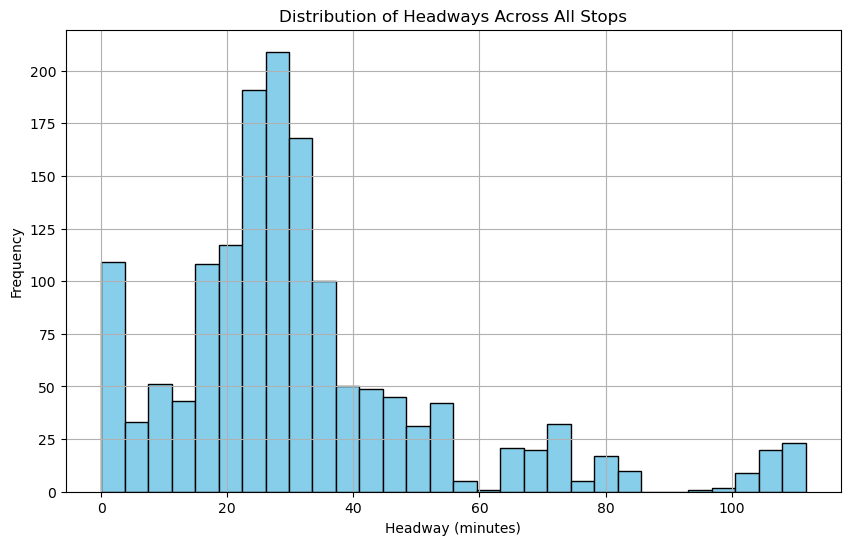

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# ======== headway 계산 ========
# 정류장별 headway 계산
headway_records = []

for stop_id, group in stopwise_arrival_df.groupby("stop_id"):
    group_sorted = group.sort_values("interpolated_arrival_time")
    
    # 최소 2개 이상 도착 시간이 있어야 headway 계산 가능
    if len(group_sorted) < 2:
        continue
    
    times = group_sorted["interpolated_arrival_time"].tolist()
    stop_name = group_sorted["stop_name"].iloc[0]

    # headway 계산 (연속된 도착 간 차이, 분 단위)
    for i in range(1, len(times)):
        delta_min = (times[i] - times[i - 1]).total_seconds() / 60
        headway_records.append({
            "stop_id": stop_id,
            "stop_name": stop_name,
            "headway_min": delta_min
        })

# ======== 결과를 데이터프레임으로 정리 ========
headway_df = pd.DataFrame(headway_records)

# ======== 분포 시각화 ========
plt.figure(figsize=(10, 6))
plt.hist(headway_df["headway_min"], bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Headway (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Headways Across All Stops")
plt.grid(True)
plt.show()


In [57]:
# 이상값 추출 (headway가 0 이하 또는 100 이상)
outlier_df = headway_df[(headway_df["headway_min"] <= 0) | (headway_df["headway_min"] >= 100)]

# 결과 확인
print(outlier_df.sort_values("headway_min"))


      stop_id                         stop_name  headway_min
1467    21989             University Bl+Fern St   101.499518
879     10627        University Bl+Easecrest Dr   102.865129
991     10665    University Bl W+Westchester Dr   102.884136
963     10659           University Bl+Reedie Dr   102.925593
1411    20531           University Bl+Inwood Av   103.826429
851     10607      University Bl+Sligo Creek Pw   103.890097
823     10573            University Bl+Gabel St   104.026279
1243    18897           University Bl+Orange Dr   104.034644
795     10545                University Bl+#728   104.039971
767     10500           University Bl+Dennis Av   104.381462
123      9848          Baltimore Av+Lakeland Rd   104.385762
739     10468       University Bl W+Royalton Rd   104.500413
711     10447          University Bl+Brunett Av   104.658387
235     10021          Baltimore Av+Tecumseh St   104.855536
683     10426           University Bl+Lorain Av   104.946221
655     10409       Univ

In [58]:
# 이상값 발생 정류장 요약
summary = outlier_df.groupby(["stop_id", "stop_name"]).agg(
    num_outliers=("headway_min", "count"),
    max_headway=("headway_min", "max"),
    min_headway=("headway_min", "min")
).reset_index()

summary.sort_values("num_outliers", ascending=False)


,stop_id,stop_name,num_outliers,max_headway,min_headway
0,9695,University Bl+Riggs Rd,1,107.626740,107.626740
1,9722,University Bl+25 Av,1,109.102243,109.102243
28,10545,University Bl+#728,1,104.039971,104.039971
29,10573,University Bl+Gabel St,1,104.026279,104.026279
30,10607,University Bl+Sligo Creek Pw,1,103.890097,103.890097
31,10627,University Bl+Easecrest Dr,1,102.865129,102.865129
32,10659,University Bl+Reedie Dr,1,102.925593,102.925593
33,10665,University Bl W+Westchester Dr,1,102.884136,102.884136
34,12027,Greenbelt+Bus Bay G,1,107.674136,107.674136
35,12101,Greenbelt Metro Dr+Cherrywood La,1,109.914284,109.914284


In [59]:
# 먼저 원본 데이터 정렬
sorted_df = stopwise_arrival_df.sort_values(["stop_id", "interpolated_arrival_time"])

# shift()를 이용해서 이전 trip 정보 추가
sorted_df["prev_trip_id"] = sorted_df.groupby("stop_id")["trip_id"].shift(1)
sorted_df["prev_arrival_time"] = sorted_df.groupby("stop_id")["interpolated_arrival_time"].shift(1)

# headway 계산
sorted_df["headway_min"] = (sorted_df["interpolated_arrival_time"] - sorted_df["prev_arrival_time"]).dt.total_seconds() / 60

# 이상값만 필터링
detailed_outliers = sorted_df[
    (sorted_df["headway_min"] <= 0) | (sorted_df["headway_min"] >= 100)
].dropna(subset=["headway_min"])

# 보기 쉽게 정렬
detailed_outliers = detailed_outliers[[
    "stop_id", "stop_name", "prev_trip_id", "trip_id", "prev_arrival_time", "interpolated_arrival_time", "headway_min"
]].sort_values("headway_min")

detailed_outliers.head()


,stop_id,stop_name,prev_trip_id,trip_id,prev_arrival_time,interpolated_arrival_time,headway_min
1520,21989,University Bl+Fern St,46710070.0,29921070,2024-06-01 11:31:34.141536461-04:00,2024-06-01 13:13:04.112601156-04:00,101.499518
911,10627,University Bl+Easecrest Dr,46710070.0,29921070,2024-06-01 11:33:07.439715910-04:00,2024-06-01 13:15:59.347466704-04:00,102.865129
1027,10665,University Bl W+Westchester Dr,46710070.0,29921070,2024-06-01 11:32:00.288645994-04:00,2024-06-01 13:14:53.336834388-04:00,102.884136
998,10659,University Bl+Reedie Dr,46710070.0,29921070,2024-06-01 11:32:36.163337393-04:00,2024-06-01 13:15:31.698901099-04:00,102.925593
1462,20531,University Bl+Inwood Av,46710070.0,29921070,2024-06-01 11:33:34.218425913-04:00,2024-06-01 13:17:23.804158003-04:00,103.826429
